## Solutions guide d'onde cf Taillard

Code reproduisant le modèle de clarinette présenté dans "Iterated maps for clarinet-like systems"

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
import os
from datetime import datetime
# %matplotlib widget

## Modèle

On travaille en pression et débit adimensionnés

<!-- $\gamma = \frac{P_m}{P_c}$ pression dans la bouche
$p = \frac{P_{int}}{P_c}$ pression à l'entrée du résonateur
$u = \frac{U Z_\infty}{P_c}$ débit à l'entrée du résonateur -->
- $\gamma = P_m/P_c$ pression dans la bouche
- $p = P_{int} / P_c$ pression à l'entrée du résonateur
- $u = U Z_\infty / P_c$ débit à l'entrée du résonateur avec $Z_\infty = \rho c/S$ l'impédance caractéristique (S section du résonateur de la clarinette)

Pour la modélisation du résonateur, on a une simple ligne de délai avec pertes :
$$p^+(t) = -\lambda p^-(t-T), \text{ avec } T = 2l/c$$

$$p(t) = p^+(t) + p^-(t)$$
$$Z_\infty u(t) = p^+(t) - p^-(t)$$

On note $p_n = p(nT)$


In [8]:
def f_iterate(x, gamma, zeta, lda):
    # X = gamma - p_n = gamma - p^+_{n} - p^-_{n} = gamma - p^+_{n} + \lambda p^+_{n-1}
    # Y = u_n + X
    # x = p^+_{n-1}
    Y = gamma + 2 * lda * x
    return gamma - X(Y, zeta) + lda * x

def X(Y, zeta):
    psi = 1/zeta**2
    mu = 9/2 * (3*Y - 1)
    if Y >= 0 and Y <= 1: # non-beating reed case, positive flow u > 0
        eta = np.sqrt(3 + psi)
        return (-2/3 * eta * np.sin(1/3 * np.arcsin((psi-mu)/(zeta * eta**3))) + 1/(3*zeta))**2
    elif Y < 0: # non-beating reed case, negative flow u < 0
        q = 1/9 * (3 - psi)
        r = -(psi + mu)/(27*zeta)
        discr = q**3 + r**2
        if discr >= 0: # In the paper it is written for discr > 0
            s = np.cbrt(r + np.sqrt(discr))
            return -(s - q/s - 1/(3 * zeta))**2
        if discr < 0:
            eta2 = np.sqrt(-3 + psi)
            return -(
                    2/3 * eta2 * np.cos(1/3 * np.arccos(- (psi+mu)/(zeta * eta2**3))) - 1/(3*zeta)
                )**2
    # Y > 1: beating reed case, Y = X, p+ = p-, u = 0
    elif Y > 1:
        return Y
    raise ValueError(f"Y = {Y} is not in the domain of definition of X")

In [9]:
# Model parameters
## Modal parameters - Length of the resonator
f = 130.81     # frequency of the note (C3)
c = 340     # speed of sound
l = c/(4*f) # length of the resonator (m) so that the fundamental frequency is f
T = (2*l)/c # time for a wave to travel back and forth (reed to resonator end and back) (s)

rho = 1.2 # air density (kg/m^3)
r = 0.08 # radius of the resonator (m)
S = np.pi * r**2 # section of the resonator (m^2)
Zc = rho*c/S # characteristic impedance of the air

# Losses
lda = .95

# Musicians parameters
gamma = .43 # pression dans la bouche adimensionnée
zeta = 0.8

print(f"Frequency: {c/(4*l)} Hz; length of the resonator {np.round(l*1e2,1)} cm")
print(f"Time for a wave to travel back and forth: {np.round(T*1e3,2)} ms")

Frequency: 130.81 Hz; length of the resonator 65.0 cm
Time for a wave to travel back and forth: 3.82 ms


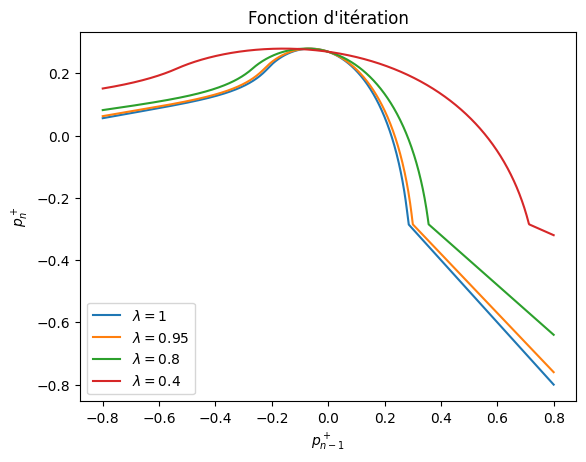

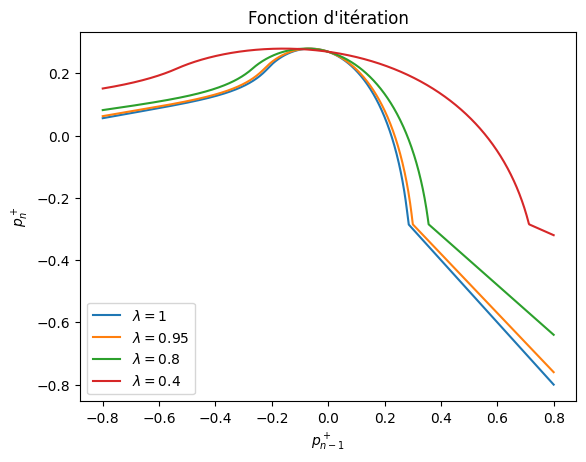

In [10]:
# Display iteration function for selected parameters

# Plot iteration function
x = np.linspace(-.8, .8, 1000)
f_iterate = np.frompyfunc(f_iterate, 4, 1)
plt.figure()

for lda_plot in [1, .95, .8, .4]:
    y = f_iterate(x, gamma, zeta, lda_plot)
    plt.plot(x, y, label=f"$\lambda = {lda_plot}$")

plt.xlabel("$p_{n-1}^+$")
plt.ylabel("$p_{n}^+$")
plt.title("Fonction d'itération")
plt.legend()
plt.show()


## Simulation

In [13]:
# Simulation main loop
nb_steps = 1000 # steps of length T

p_p = np.zeros(nb_steps)
p_m = np.zeros(nb_steps)

for i in range(1, nb_steps):
    p_p[i] = f_iterate(p_p[i-1], gamma, zeta, lda)

p_m[1:] = -1/lda * p_p[:-1]

(0.0, 0.19130819528342652)

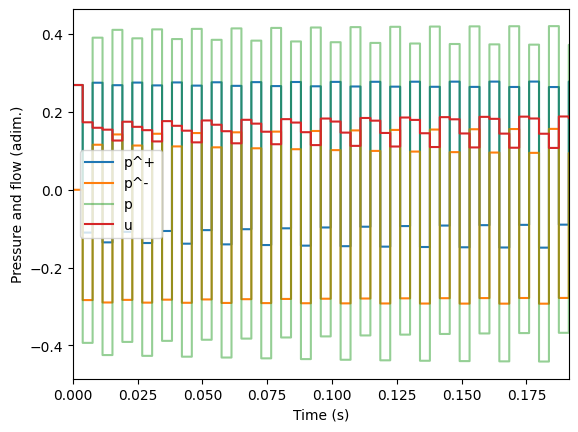

In [14]:
u = (p_p - p_m)
p = (p_p + p_m)
t_steps = np.linspace(0, nb_steps * T, nb_steps)

step_min = 0
step_max = 50
plt.figure()
# plt.plot(t_steps[step_min:step_max], p_p[step_min:step_max], label="p^+")
plt.step(t_steps, p_p, label="p^+")
plt.step(t_steps, p_m, label="p^-")
plt.step(t_steps, p, label="p", alpha=0.5)
plt.step(t_steps, u, label="u")
plt.xlabel("Time (s)")
plt.ylabel("Pressure and flow (adim.)")
plt.legend()
plt.xlim(t_steps[step_min], t_steps[step_max])
# plt.ylim(min(p_p[step_min:step_max]), max(p_p[step_min:step_max]))


In [15]:
sr = 44100
nb_samples = np.floor(nb_steps * T * sr).astype(int)
t = np.linspace(0, nb_steps * T, nb_samples)

# p_sr = np.interp(t, np.arange(nb_steps) * T, p) 
p_sr = np.array([p[int((i*1/sr)//T)] for i in range(nb_samples)])

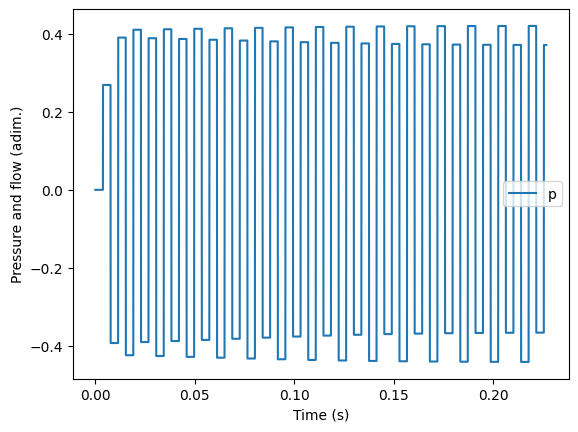

In [16]:
i_start = 0
i_end = 10000
plt.figure()
plt.plot(t[i_start:i_end], p_sr[i_start:i_end], label="p")
plt.xlabel("Time (s)")
plt.ylabel("Pressure and flow (adim.)")
plt.legend()

In [17]:
if not os.path.exists("sounds"):
    os.makedirs("sounds")
path = os.path.join("sounds", f"clarinet_gamma-{gamma}_zeta-{zeta}_{datetime.now().strftime('%d%m-%H%M')}.wav")
write(path, sr, p_sr)

### Analyse du son

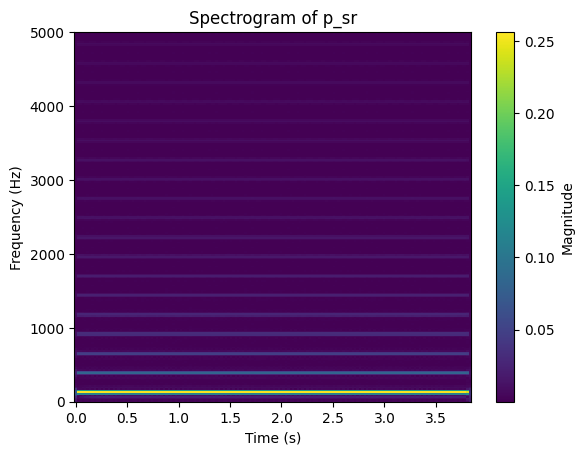

In [18]:
from scipy.signal import stft, find_peaks
from scipy.fft import fft, fftfreq

# Perform STFT
frequencies, times, spectrogram = stft(p_sr, fs=sr, nperseg=2048, noverlap=1024, nfft=2048)

# Plot spectrogram
plt.figure()
plt.pcolormesh(times, frequencies, np.abs(spectrogram), shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 5000)
plt.title('Spectrogram of p_sr')
plt.show()


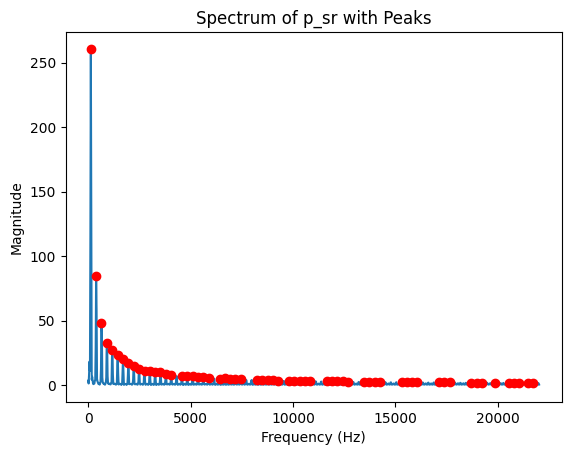

In [19]:
# Affichage du spectre une fois le son stabilisé
i_start = 5000
Nfft = 2048
X = fft(p_sr[i_start:i_start+Nfft]*np.hanning(Nfft))
# f = np.arange(Nfft) * sr / Nfft
f = fftfreq(Nfft, 1/sr)

# Find peaks in the spectrum
peaks, _ = find_peaks(np.abs(X[:Nfft//2]), threshold=0.5, distance=10)

plt.figure()
plt.plot(f[:Nfft//2], np.abs(X[:Nfft//2]))
plt.plot(f[peaks], np.abs(X[peaks]), 'ro')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Spectrum of p_sr with Peaks")
plt.show()

In [20]:
print(f"Premier pic du spectre à {np.round(f[peaks[0]],2)} Hz")
print(f"Second pic du spectre à {np.round(f[peaks[1]],2)} Hz")
f0 = f[peaks[0]]
f1 = f[peaks[1]]
print(f"Rapport d'harmonicité {f1/f0=}")

Premier pic du spectre à 129.2 Hz
Second pic du spectre à 387.6 Hz
Rapport d'harmonicité f1/f0=3.0
